In [1]:
import shap

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
X = (train_df.iloc[:,1:].values).astype('float32')
Y = train_df.iloc[:,0].values.astype('int32')
test = test_df.values.astype('float32')

In [4]:
X = X.reshape(X.shape[0], 28, 28, 1)
Y = to_categorical(Y)
test = test.reshape(test.shape[0], 28, 28, 1)

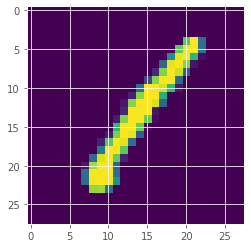

In [5]:
#Confirm the image.
plt.imshow(X[0].reshape(28,28))
plt.show()

In [6]:
X = X.astype("float32") / 255
test = test.astype("float32") / 255

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=0)

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 4, activation="relu", input_shape=(28,28,1)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = 2, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
batch_size = 100
epochs = 30

hist = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 378 steps, validate on 4200 samples
Epoch 1/30
378/378 - 16s - loss: 0.0278 - accuracy: 0.8007 - val_loss: 0.0094 - val_accuracy: 0.9376
Epoch 2/30
378/378 - 14s - loss: 0.0097 - accuracy: 0.9361 - val_loss: 0.0039 - val_accuracy: 0.9755
Epoch 3/30
378/378 - 15s - loss: 0.0069 - accuracy: 0.9552 - val_loss: 0.0029 - val_accuracy: 0.9810
Epoch 4/30
378/378 - 14s - loss: 0.0054 - accuracy: 0.9647 - val_loss: 0.0026 - val_accuracy: 0.9836
Epoch 5/30
378/378 - 14s - loss: 0.0046 - accuracy: 0.9698 - val_loss: 0.0022 - val_accuracy: 0.9857
Epoch 6/30
378/378 - 15s - loss: 0.0042 - accuracy: 0.9726 - val_loss: 0.0023 - val_accuracy: 0.9860
Epoch 7/30
378/378 - 14s - loss: 0.0038 - accuracy: 0.9750 - val_loss: 0.0019 - val_accuracy: 0.9869
Epoch 8/30
378/378 - 13s - loss: 0.0034 - accuracy: 0.9778 - val_loss: 0.0018 - val_accuracy: 0.9883
Epoch 9/30
378/378 - 13s - loss: 0.0032 - acc

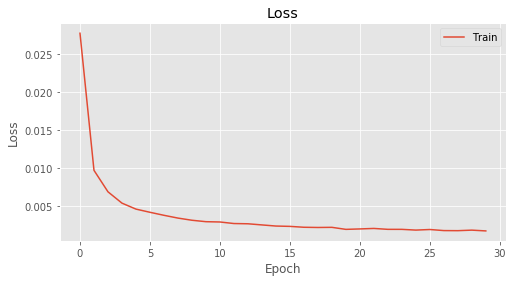


Test accuracy: 0.989047646522522


In [12]:
plt.figure(figsize=(8, 4))
plt.plot(hist.history["loss"])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()

pred = model.predict(X_val)

test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=0)
print(f'\nTest accuracy: {test_acc}')

In [13]:
Y_pred_classes = np.argmax(pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1)

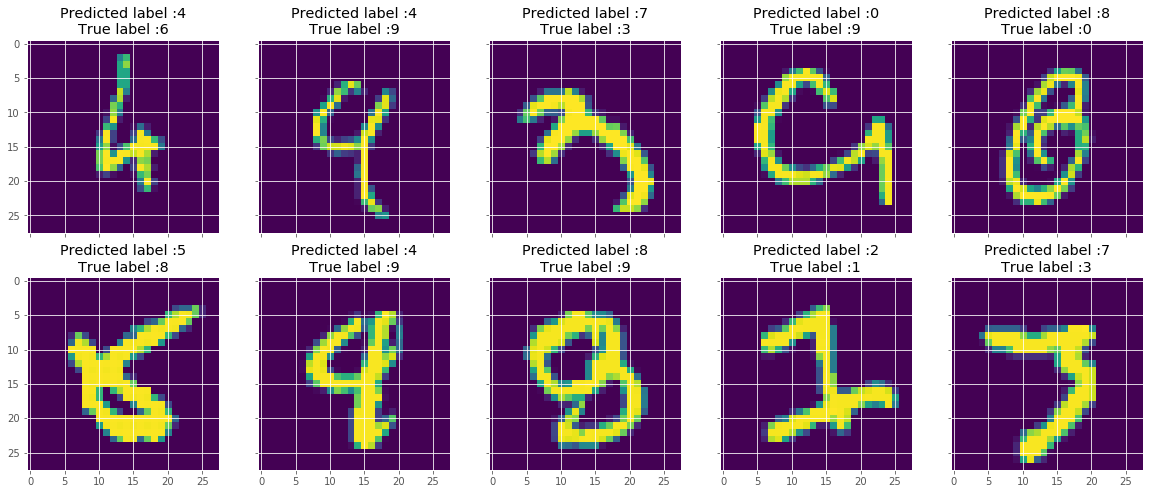

In [14]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()
    
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-10:]

display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [15]:
import shap

#When describing Deep Learning, we use DeepExplainer.
explainer = shap.DeepExplainer(model, (X[0:1000]))

#Check out the 10 data that the model has mistakenly predicted.
for i in most_important_errors:
    
    #Calculates the SHAP value.
    shap_values = explainer.shap_values(X_val_errors[[i]])
    
    #The following two lines are extras. It works even if you turn it off.
    index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(Y_pred_errors[i][x]) for x in range(10)]).reshape(1,10)
    print("Predicted label :{}\nTrue label :{}".format(Y_pred_classes_errors[i],Y_true_errors[i]))
    
    #Displays the results.
    shap.image_plot(shap_values, X_val_errors[[i]] ,index_names ,show=False)
    plt.show()

Using TensorFlow backend.


TypeError: Tensor is unhashable if Tensor equality is enabled. Instead, use tensor.experimental_ref() as the key.